In [3]:
import sys

preprocessing_path = 'C:\\Users\\joshh\\Desktop\\Uni\\Soton Uni - Yr 3\\COMP3200\\fake-news-profiling\\classifier\\preprocessing'
if preprocessing_path not in sys.path:
    sys.path.insert(1, preprocessing_path)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
import string
from xml.sax.saxutils import unescape
import demoji
import numpy as np
from bs4 import BeautifulSoup
from unidecode import unidecode

from nltk.corpus import stopwords
from wordcloud import WordCloud
from colour import Color

import ipynb.fs.full.parse_datasets as datasets

# Parse the dataset

In [5]:
data = datasets.parse_dataset("datasets", "en", to_pandas=True)
data = data.sample(frac=0.7) # Shuffle rows and return 70% of the data (training set)
truthful_tweets = data.loc[data['truth_value'] == '0'].iloc[:, 2:].values.flatten()
fake_tweets = data.loc[data['truth_value'] == '1'].iloc[:, 2:].values.flatten()

print("Number of truthful users:", int(len(truthful_tweets)/100))
print("Number of fake users:", int(len(fake_tweets)/100))

Number of truthful users: 106
Number of fake users: 104


In [6]:
data.head()

,author_id,truth_value,tweet_1,tweet_2,tweet_3,tweet_4,tweet_5,tweet_6,tweet_7,tweet_8,...,tweet_91,tweet_92,tweet_93,tweet_94,tweet_95,tweet_96,tweet_97,tweet_98,tweet_99,tweet_100
104,bq7ikhzq7xt66si1kmprz9vdjpnl5eqp,1,New #USER#: The War in Yemen Has Killed Thousa...,New #USER#: Rihanna Wears a Denim Skirt as a T...,New #USER#: 21 Apps You Should Download If You...,New #USER#: What to Do if Your Partner Doesn't...,New #USER#: Tennessee Teen on Trial for Ex-Gir...,New #USER#: Pat McGrath Launches Met Heavenly ...,New #USER#: Republican Politician Rep. Kelly T...,New #USER#: Netflix Called Out Teen Dramas for...,...,New #USER#: National Teacher of the Year Mandy...,New #USER#: Rihanna Wears Metallic Highlighter...,New #USER#: Sasha Lane Wears Jewel Locs Hairst...,New #USER#: Childish Gambino Drops New Music V...,New #USER#: Samira Wiley Delivered Empowering ...,"New #USER#: Storybook Cosmetics to Launch ""Sta...",New #USER#: Miley Cyrus's Best Red Carpet Beau...,New #USER#: Weekly Horoscopes May 7-13 #URL#,New #USER#: Michelle Obama on the 2016 Electio...,New #USER#: Zendaya Wears Armor to the Met Gal...
89,9i4x0l6lzayvpooc4ybugncxxd58dvee,1,SBI customer? ATMs may run dry over weekend du...,Soccer: Oman Name Ivankovic to Replace Koeman ...,Effects of Coronavirus Begin Echoing Far From ...,Navy to expand daycare space at Jackson Park t...,Christine Sinclair's top goal: make soccer mat...,Sons of Italy dining hall finally reopens afte...,LETTER: Current economy - Peninsula Daily News...,PM Narendra Modi and Brazil President Bolsonar...,...,Jeff Bezos is in India. Amazon has a ton on th...,Euro Zone Economy Remains Weak but Green Shoot...,Woman dies in Australia Day lamington-eating c...,Trump teases plan to roll back key Obama-era w...,Frost quakes! The science behind the shaking -...,U.S.-China Trade Deal Reality Check: What’s Ne...,Study: Washington's immigrants bolster the sta...,5 things to know for February 11: New Hampshir...,Virus death toll rises in China as Germany ide...,Satellite spies gigantic 'fuzzball' clouds spr...
295,zuelpgcp4186rxrhifbslyrdfhhaxxt8,0,Court overturns rescue ship captain's convicti...,Quick hit of snow expected in Northeast as maj...,"RT #USER#: Today, we give thanks for our bless...",Ikea to pay $46 million settlement after dress...,RT #USER#: My top 5 most ANNOYING people in al...,RT #USER#: Another #USER# record for Bill Beli...,RT #USER#: I have an important announcement #H...,Authorities have 'good reason to believe' that...,...,RT #USER#: Howdy do 🤠 #URL#,RT #USER#: The DOJ handbook states “the rule o...,RT #USER#: I’ll run through a ************* fa...,The Note: Trump stirs debates in Congress with...,Bolton's offer to testify ramps up pressure on...,Shelter dog finds forever home after 6 years w...,RT #USER#: 11 straight playoff appearances for...,Abandoned kitten who lost eyesight finds home ...,Police warn that abbreviating 2020 on legal do...,"60 dead in landslides, flash floods in Indones..."
26,2zszbxip2txqztt22cogmmnatf3egx3f,0,#USER# can i get your contact info?,RT #USER#: Follow #HASHTAG# for the largest ne...,Best bus driver on the 95 right now. I feel li...,"RT #USER#: ""I'm feeling honoured,"" says #HASHT...",Liberal candidate for Carleton-Mississippi Mil...,YouTube is a new way of creating/consuming med...,#USER# open for #USER# to kick off Orientation...,RT #USER#: RT #USER#: #USER# camp saying it's ...,...,RT #USER#: The cat seems sufficiently out of t...,Positive vibes of a job well done at Liberal c...,Dubai's fur industry is feeling the heat in th...,Best part of working in the office alone: I ca...,#USER# are you voting in the UK election?,#USER# cancels 2 more campuses in Saudi Arabia...,#USER# I'm a journalist #USER# writing a piece...,RT #USER#: Excited to welcome #USER# to the gr...,#USER# rough start in #USER# lead to the cance...,Summer fun begins in two days. Vacation + movi...
120,dju5g8omebrjvo940rvdsvjx68ej65tv,0,"Trouble, As Boko Haram Rejects The Payment Of 

# Helper functions

In [16]:
digits = set("0123456789")
printable = set(string.printable)
punctuation = set(string.punctuation)
punctuation.remove('#')

In [8]:
def clean_text(text, remove_punc=True, remove_non_print=True, remove_emojis=True, 
              remove_digits=True, remove_tags=False):
    """ Clean text by removing certain characters (e.g. punctuation) """
    if remove_emojis:
        text = demoji.replace(text, "")
        
    chars = []
    for char in text:
        if not ((remove_punc and char in punctuation) or
            (remove_non_print and char not in printable) or
            (remove_digits and char in digits)):
            chars.append(char)
        
    cleaned = "".join(chars)
    if remove_tags:
        return re.sub('#[A-Z]+#', "", cleaned)
    
    return cleaned

# Tweet lengths

## Number of characters used in tweets, per user
* Count the number of characters in a users 100 tweets and then take the mean and median

In [14]:
def tweet_lengths_per_user(data_array):
    """ Returns a Numpy array of average and median tweet lengths (in chars) for each user """
    char_lens = np.asarray([
        [len(tweet) for tweet in user_tweets]
        for user_tweets in data_array
    ])
    means = np.asarray([np.mean(tweet_lens) for tweet_lens in char_lens])
    medians = np.asarray([np.median(tweet_lens) for tweet_lens in char_lens])
    return means, medians

Average tweet lengths (in characters)


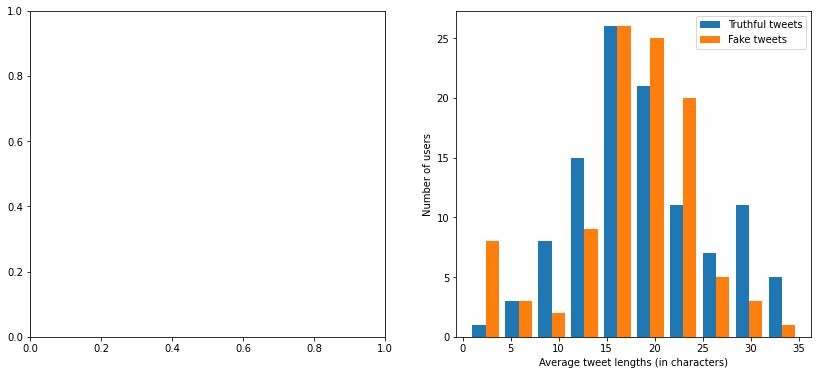

In [153]:
def test(data_array):
    char_lens = np.asarray([
        [len(tweet) for tweet in user_tweets]
        for user_tweets in data_array
    ])
    means = np.asarray([np.mean(tweet_lens) for tweet_lens in char_lens])
    return [np.sqrt(np.sum(vals**2)/100) for vals in char_lens - means.reshape(-1, 1)]

fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

truthful_lens = test(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values)
fake_lens = test(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values)

# Truth label plot
ax[1].hist((truthful_lens, fake_lens), label=("Truthful tweets", "Fake tweets"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Average tweet lengths (in characters)")
ax[1].legend()
print("Average tweet lengths (in characters)")

Average tweet lengths (in characters)


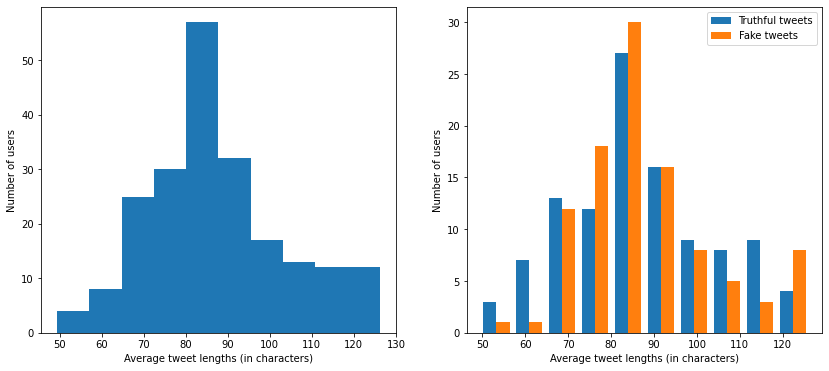

In [143]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

data_lens = tweet_lengths_per_user(data.iloc[:, 2:].values)
truthful_lens = tweet_lengths_per_user(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values)
fake_lens = tweet_lengths_per_user(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values)

# All tweets plot
ax[0].hist(data_lens[0])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Average tweet lengths (in characters)")

# Truth label plot
ax[1].hist((truthful_lens[0], fake_lens[0]), label=("Truthful tweets", "Fake tweets"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Average tweet lengths (in characters)")
ax[1].legend()
print("Average tweet lengths (in characters)")

Median tweet lengths (in characters)


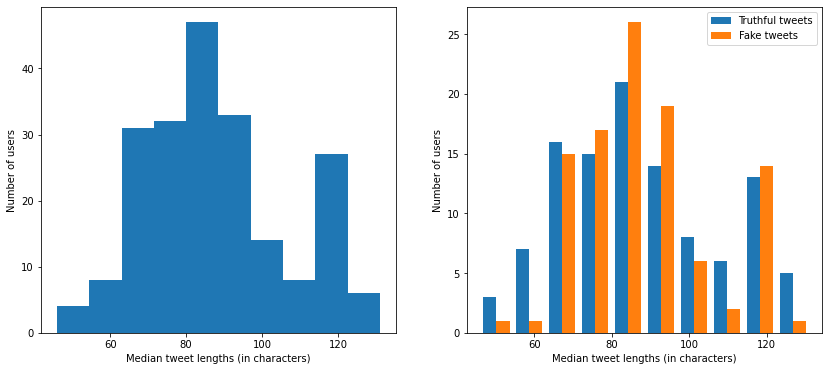

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

# All tweets plot
ax[0].hist(data_lens[1])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Median tweet lengths (in characters)")

# Truth label plot
ax[1].hist((truthful_lens[1], fake_lens[1]), label=("Truthful tweets", "Fake tweets"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Median tweet lengths (in characters)")
ax[1].legend()
print("Median tweet lengths (in characters)")

Findings:
* Truthful users are more likely to write very short tweets
* On average fake users write the longest tweets, but medians show that truthful users are more likely to have higher tweet 
  medians
* Fake users write mid-length tweets than truthful users

## Number of words used in tweets, per user
* Count the number of words in a users 100 tweets and then take the mean and median

In [17]:
def remove_punc(text):
    """ Removes all punctuation from some text (excluding hashtags '#') """
    punc = set(string.punctuation)
    prin = set(string.printable)
    punc.remove("#")
    return "".join(c.lower() for c in text if c not in punc and c in prin)

def tweets_to_words(data_array):
    """ Returns a Numpy array where tweets have been split by spaces (after removing punctuation) """
    return np.asarray([
        [remove_punc(tweet).split(" ") for tweet in user_tweets] 
        for user_tweets in data_array
    ])

Average tweet lengths (in words)


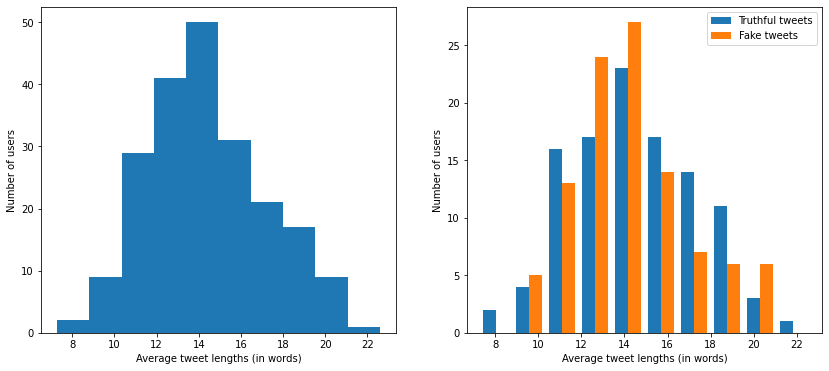

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

data_lens = tweet_lengths_per_user(
    tweets_to_words(data.iloc[:, 2:].values))
truthful_lens = tweet_lengths_per_user(
    tweets_to_words(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values))
fake_lens = tweet_lengths_per_user(
    tweets_to_words(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values))

# All tweets plot
ax[0].hist(data_lens[0])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Average tweet lengths (in words)")

# Truth label plot
ax[1].hist((truthful_lens[0], fake_lens[0]), label=("Truthful tweets", "Fake tweets"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Average tweet lengths (in words)")
ax[1].legend()
print("Average tweet lengths (in words)")

Median tweet lengths (in words)


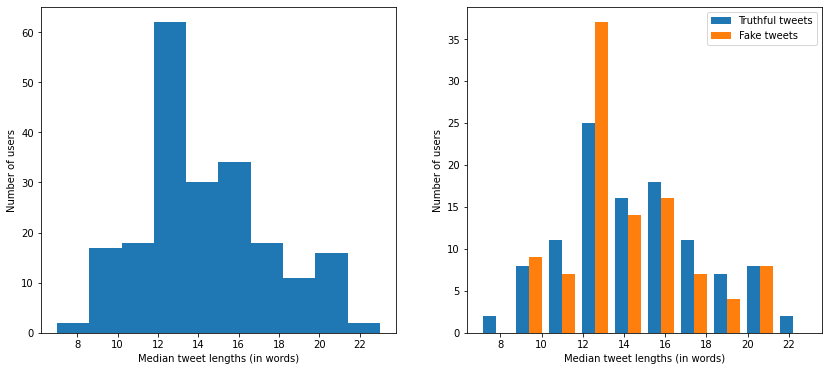

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

# All tweets plot
ax[0].hist(data_lens[1])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Median tweet lengths (in words)")

# Truth label plot
ax[1].hist((truthful_lens[1], fake_lens[1]), label=("Truthful tweets", "Fake tweets"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Median tweet lengths (in words)")
ax[1].legend()
print("Median tweet lengths (in words)")

Findings:
* Truthful users typically use the fewest words or the most words in tweets - shown in both mean and medians
* Similar to with char lengths, fake users normally use mid-length tweets (when measuring length by words)

## Word lengths of users
* Count the lengths of all words used by a user, and then take the mean and median

Findings:
* Fake news authors use (on average) longer words, while truthful authors use shorter words

In [136]:
def tweets_to_flattened_words(data_array):
    """ Returns a Numpy array where tweets have been split by spaces (after removing punctuation) and flattened """
    return np.asarray([
        [word for tweet in user_tweets for word in remove_punc(tweet).split()] 
        for user_tweets in data_array
    ])

Average word lengths


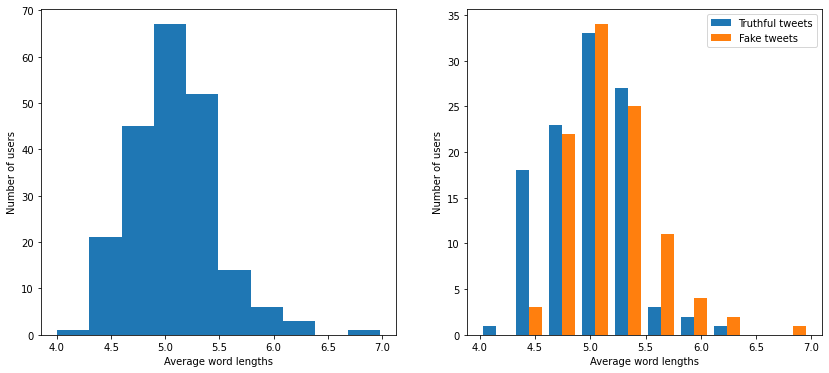

In [137]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

data_lens = tweet_lengths_per_user(
    tweets_to_flattened_words(data.iloc[:, 2:].values))
truthful_lens = tweet_lengths_per_user(
    tweets_to_flattened_words(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values))
fake_lens = tweet_lengths_per_user(
    tweets_to_flattened_words(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values))

# All tweets plot
ax[0].hist(data_lens[0])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Average word lengths")

# Truth label plot
ax[1].hist((truthful_lens[0], fake_lens[0]), label=("Truthful tweets", "Fake tweets"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Average word lengths")
ax[1].legend()
print("Average word lengths")

Median word lengths


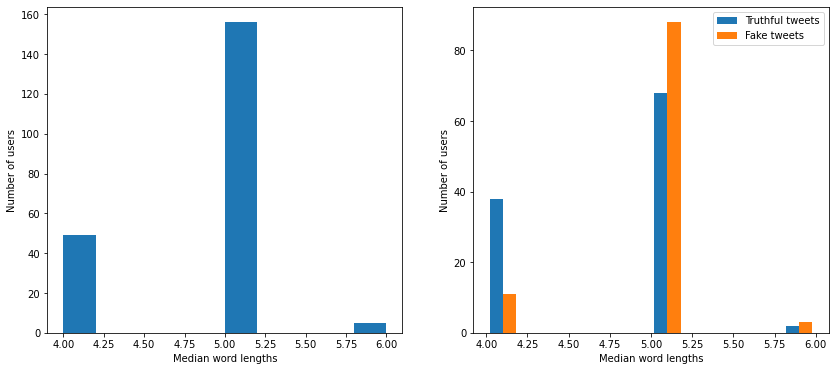

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

# All tweets plot
ax[0].hist(data_lens[1])
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Median word lengths")

# Truth label plot
ax[1].hist((truthful_lens[1], fake_lens[1]), label=("Truthful tweets", "Fake tweets"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Median word lengths")
ax[1].legend()
print("Median word lengths")

Findings:
* Truthful users use shorter words
* Fake users use longer words

# Types of words used

## Frequent words

In [23]:
def tweets_to_word_freq(tweets_data_array):
    """ Returns a dict of words mapped to their frequency (ignoring stopwords) """
    word_freq = dict()
    english_stopwords = set([remove_punc(word) for word in stopwords.words('english')])

    for word in [word for tweet in tweets_data_array for word in remove_punc(tweet).split(" ")]:
        if word not in english_stopwords:
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
    
    return word_freq

In [24]:
# Wordcloud data
data_freq = tweets_to_word_freq(data.iloc[:, 2:].values.flatten())
truthful_freq = tweets_to_word_freq(truthful_tweets)
fake_freq = tweets_to_word_freq(fake_tweets)

color_map = dict()
for k, v in truthful_freq.items():
    other_v = fake_freq[k] if k in fake_freq else 0
    color_map[k] = v/(v+other_v)

def color_map_func(word, **kwargs):
    color_val = color_map[word] if word in color_map else 0
    return Color(rgb=(1-color_val, color_val, 0)).hex

Wordclouds of frequent words


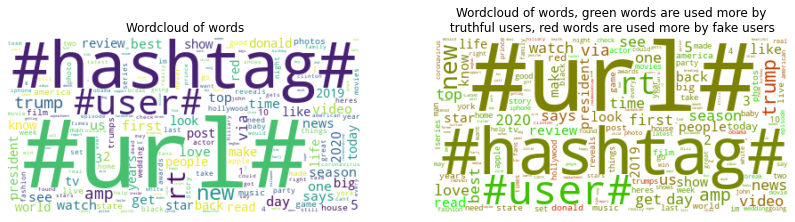

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 8))

wc = WordCloud(background_color="white")
wc.fit_words(data_freq)
ax[0].imshow(wc, interpolation="bilinear")
ax[0].axis("off")
ax[0].set_title("Wordcloud of words")

wc = WordCloud(background_color="white", color_func=color_map_func)
wc.fit_words(data_freq)
ax[1].imshow(wc, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title("Wordcloud of words, green words are used more by\n truthful users, red words are used more by fake users")

print("Wordclouds of frequent words")

Findings:
* The most-used words are tagrs (url, hashtag, user, rt)
* User tags seem to be used mostly by truthful users
* 'donald', 'trump', 'obama', 'hillary' seem to be the words most used primarily by fake users

How could I use this?
* Counting the different tags for each user and passing them into a model
* We cannot count raw words like 'trump' or 'obama' as this would limit the future potential of our model. Instead it may be possible to use a remote political API to count usage of political terms instead

## Use of tags

In [26]:
def count_term_in_tweets(tweets_array, term):
    count = [tweet.count(term) for tweet in tweets_array]
    return (sum(count), np.mean(count), np.median(count))

def tweets_to_tag_freq_per_user(data_array):
    return [
        {
            'RT': np.asarray(count_term_in_tweets(user_tweets, 'RT')),
            '#USER#': np.asarray(count_term_in_tweets(user_tweets, '#USER#')),
            '#HASHTAG#': np.asarray(count_term_in_tweets(user_tweets, '#HASHTAG#')),
            '#URL#': np.asarray(count_term_in_tweets(user_tweets, '#URL#')),
        } 
        for user_tweets in data_array
    ]

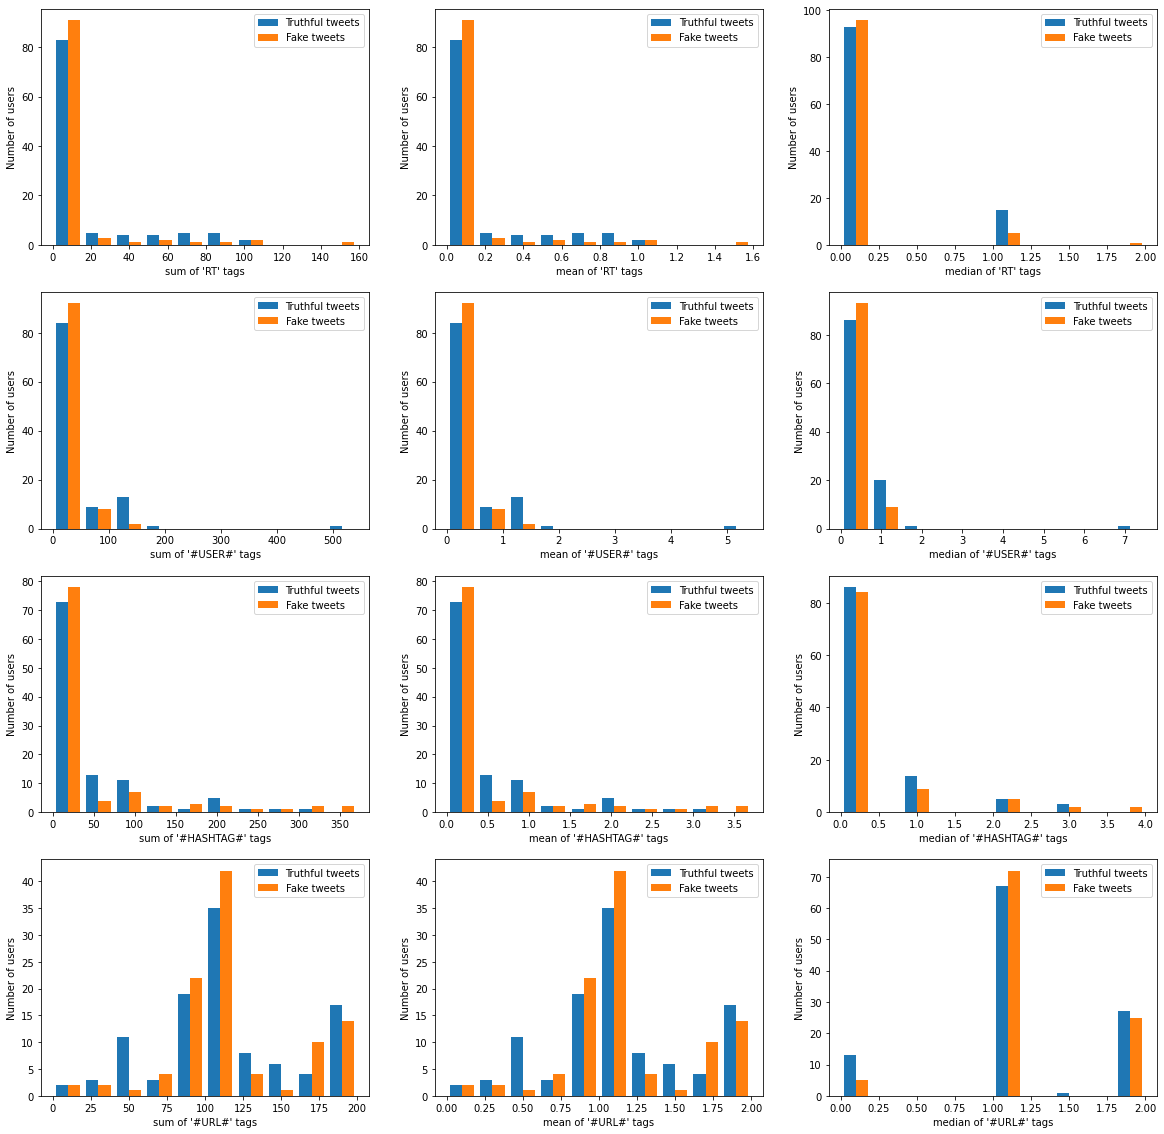

In [27]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))

tags = ['RT', '#USER#', '#HASHTAG#', '#URL#']
truthful_terms = tweets_to_tag_freq_per_user(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values)
fake_terms = tweets_to_tag_freq_per_user(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values)

# Truth label plots
for row, tag in enumerate(tags):
    truthful_hist_data = np.asarray([user[tag] for user in truthful_terms])
    fake_hist_data = np.asarray([user[tag] for user in fake_terms])
    
    for col in range(3):  
        ax[row][col].hist(
            (truthful_hist_data[:, col], fake_hist_data[:, col]),
            label=("Truthful tweets", "Fake tweets"))
        ax[row][col].set_ylabel("Number of users")
        ax[row][col].set_xlabel(f"{'sum' if col == 0 else ('mean' if col == 1 else 'median')} of '{tag}' tags")
        ax[row][col].legend()

Findings:
* Fake users seem to use fewer RT, #USER#, and #HASHTAG# tags
* However, they generally use more #URL# tags

How could I use this?
* Count mean and medians of these terms and push them through a basic Logistic Regression model, or create some user embeddings using them to push through a more complex model

# Types of characters used

## Letter casing
* Look at the average letter casing of users

In [54]:
def average_char_casing_per_user(data_array):
    """ Returns Numpy arrays of the average character casings (uncased/lowercase and cased/uppercase) """
    uncased = [
        np.mean([sum([c.islower() for c in tweet]) for tweet in user_tweets]) 
        for user_tweets in data_array
    ]
    cased = [
        np.mean([sum([c.isupper() for c in tweet]) for tweet in user_tweets]) 
        for user_tweets in data_array
    ]
    return uncased, cased

Average user character casing


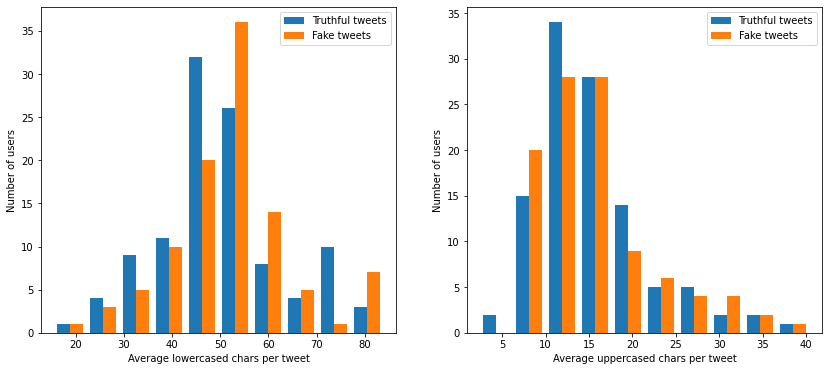

In [55]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

truthful_casing = average_char_casing_per_user(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values)
fake_casing = average_char_casing_per_user(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values)

# Uncased
ax[0].hist((truthful_casing[0], fake_casing[0]), label=("Truthful tweets", "Fake tweets"))
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Average lowercased chars per tweet")
ax[0].legend()

# Cased
ax[1].hist((truthful_casing[1], fake_casing[1]), label=("Truthful tweets", "Fake tweets"))
ax[1].set_ylabel("Number of users")
ax[1].set_xlabel("Average uppercased chars per tweet")
ax[1].legend()
print("Average user character casing")

## Use of emojis

In [121]:
def count_emojis(user_tweets):
    count = 0
    for tweet in user_tweets:
        emojis_found = list(demoji.findall(tweet).keys())
        for emoji in emojis_found:
            count += len(re.findall(emoji, tweet))
    
    return count

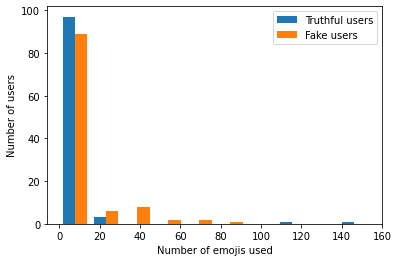

In [122]:
truthful_tweets_per_user = data.loc[data['truth_value'] == '1'].iloc[:, 2:].values
fake_tweets_per_user = data.loc[data['truth_value'] == '0'].iloc[:, 2:].values

truthful_emojis = [count_emojis(user_tweets) for user_tweets in truthful_tweets_per_user]
fake_emojis = [count_emojis(user_tweets) for user_tweets in fake_tweets_per_user]
plt.hist((truthful_emojis, fake_emojis), label=("Truthful users", "Fake users"))
plt.xlabel("Number of emojis used")
plt.ylabel("Number of users")
plt.legend()

## Use of punctuation

In [66]:
def average_punc_per_user(data_array):#
    """ Returns Numpy array of the average amount of punctuation used """
    punc = set(string.punctuation)
    punc.remove('#')
    return np.asarray([
        np.mean([sum([c in punc for c in tweet]) for tweet in user_tweets]) 
        for user_tweets in data_array
    ])

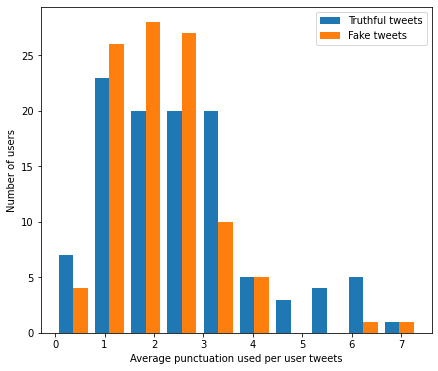

In [139]:
fig, ax = plt.subplots(ncols=1, figsize=(7, 6))

truthful_punc = average_punc_per_user(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values)
fake_punc = average_punc_per_user(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values)

# Punctuation
ax.hist((truthful_punc, fake_punc), label=("Truthful tweets", "Fake tweets"))
ax.set_ylabel("Number of users")
ax.set_xlabel("Average punctuation used per user tweets")
ax.legend()

# Sentiment
* Look at average sentiment per user

According to vaderSentiment:
* positive sentiment: compound score >= 0.05
* neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
* negative sentiment: compound score <= -0.05

In [99]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

In [104]:
def polarity_scores(text, analyzer):
    polarity_dict = analyzer.polarity_scores(text)
    return np.asarray([
        polarity_dict['pos'],
        polarity_dict['neu'],
        polarity_dict['neg'],
        polarity_dict['compound'],
    ])

def average_sentiment_per_user(data_array):
    """ Returns Numpy array of the average sentiment of each user; 
    Returned sentiment is an array of [positive, neural, negative, compound] """
    analyzer = SentimentIntensityAnalyzer()
    return np.asarray([
        np.mean([polarity_scores(tweet, analyzer) for tweet in user_tweets], axis=0) 
        for user_tweets in data_array
    ])

Text(0.5, 0, 'Average compound sentiment')

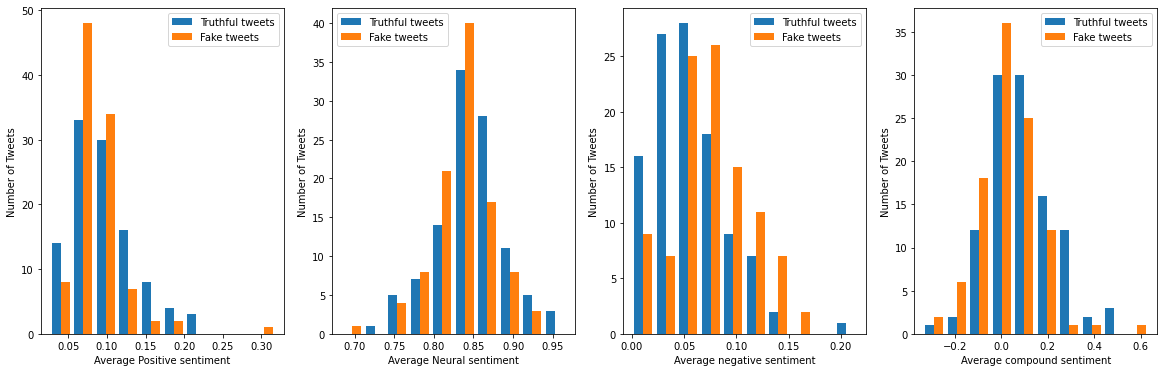

In [130]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 6))

truthful_sentiment = average_sentiment_per_user(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values)
fake_sentiment = average_sentiment_per_user(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values)

for col in range(4):
    ax[col].hist((truthful_sentiment[:, col], fake_sentiment[:, col]), label=("Truthful tweets", "Fake tweets"))
    ax[col].set_ylabel("Number of Tweets")
    ax[col].legend()
    
ax[0].set_xlabel("Average Positive sentiment")
ax[1].set_xlabel("Average Neural sentiment")
ax[2].set_xlabel("Average negative sentiment")
ax[3].set_xlabel("Average compound sentiment")

Findings:
* Fake users have higher negative sentiment than truthful users
* Higher positive sentiments are normally truthful users

## Sentiment box plot of a user

In [174]:
import seaborn as sb

In [175]:
user_tweets = data.iloc[0, 2:].values.flatten()
user_tweets_sent = [sentiment_analyser.polarity_scores(tweet)['compound'] for tweet in user_tweets]

<AxesSubplot:>

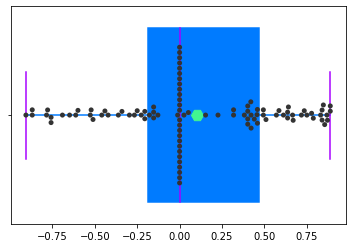

In [176]:
bp = sb.boxplot(x=user_tweets_sent,
               showmeans=True,
               whiskerprops=dict(color="#007bff"),
               flierprops=dict(color="#a600ff"),
               medianprops=dict(color="#a600ff"),
               meanprops=dict(
                   marker='H',
                   markeredgecolor='#42f590',
                   markerfacecolor='#42f590',
                   markersize=12,),
               boxprops=dict(color="#007bff"),
               capprops=dict(color="#a600ff"),
               )
sb.swarmplot(x=user_tweets_sent, color=".2")

# Readability
* Using the Automated Readability Index - https://en.wikipedia.org/wiki/Automated_readability_index

In [15]:
import textstat

In [28]:
def average_automated_readability_index(data_array):
    """ Returns Numpy array of the average Automated Readability Index of each user """
    return np.asarray([
        np.mean([textstat.automated_readability_index(tweet) for tweet in user_tweets], axis=0) 
        for user_tweets in data_array
    ])

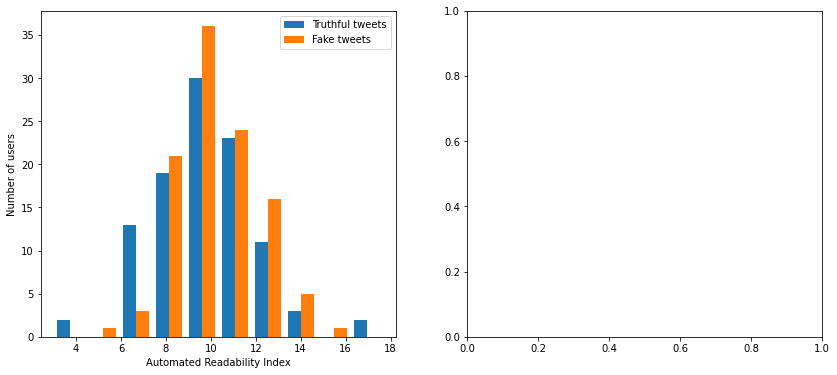

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

truthful_readability = average_automated_readability_index(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values)
fake_readability = average_automated_readability_index(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values)

# Uncased
ax[0].hist((truthful_readability, fake_readability), label=("Truthful tweets", "Fake tweets"))
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Automated Readability Index")
ax[0].legend()

# Named Entity Recognition
* Use Spacy to extract named entities from tweets

In [9]:
import spacy
spacy_nlp = spacy.load("en_core_web_sm")

In [28]:
def extract_named_entities(data_array):
    """ Returns Numpy array of the named entities used in each users tweets """
    return np.asarray([
        np.asarray([spacy_nlp(clean_text(tweet, remove_tags=True)).ents for tweet in user_tweets])
        for user_tweets in data_array
    ])

In [29]:
truthful_entities = extract_named_entities(data.loc[data['truth_value'] == '0'].iloc[:, 2:].values)
fake_entities = extract_named_entities(data.loc[data['truth_value'] == '1'].iloc[:, 2:].values)

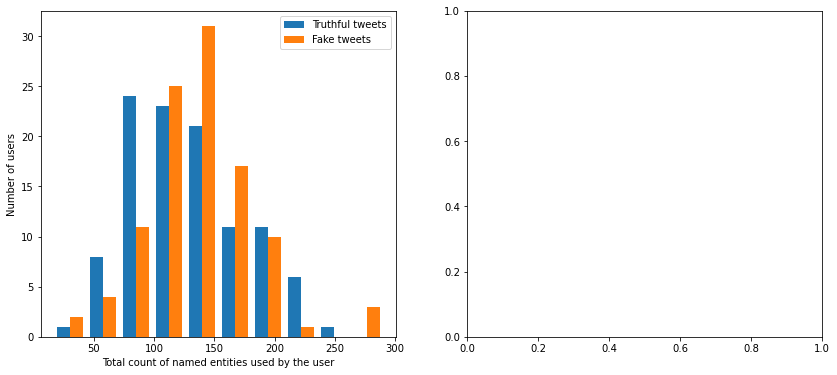

In [65]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

truthful_entities_count = [np.sum([len(entities) for entities in user]) for user in truthful_entities]
fake_entities_count = [np.sum([len(entities) for entities in user]) for user in fake_entities]

# Uncased
ax[0].hist((truthful_entities_count, fake_entities_count), label=("Truthful tweets", "Fake tweets"))
ax[0].set_ylabel("Number of users")
ax[0].set_xlabel("Total count of named entities used by the user")
ax[0].legend()

In [60]:
spacy_entity_labels = ["PERSON", "NORP", "FAC", "ORG", "GPE", "LOC", "PRODUCT", "EVENT", "WORK_OF_ART", "LAW", "LANGUAGE",
                      "DATE", "TIME", "PERCENT", "MONEY", "QUANTITY", "ORDINAL", "CARDINAL"]

for label in spacy_entity_labels:
    tc = np.mean([np.sum([np.sum([1 if e.label_ == label else 0 for e in entities]) for entities in user]) 
          for user in truthful_entities])
    fc = np.mean([np.sum([np.sum([1 if e.label_ == label else 0 for e in entities]) for entities in user]) 
          for user in fake_entities])
    print(f"Label: {label} - Truthful {tc} - Fake {fc}")

Label: PERSON - Truthful 43.64150943396226 - Fake 51.46153846153846
Label: NORP - Truthful 4.764150943396227 - Fake 7.461538461538462
Label: FAC - Truthful 1.6415094339622642 - Fake 1.3942307692307692
Label: ORG - Truthful 38.471698113207545 - Fake 40.45192307692308
Label: GPE - Truthful 16.17924528301887 - Fake 17.5
Label: LOC - Truthful 1.6226415094339623 - Fake 1.4134615384615385
Label: PRODUCT - Truthful 1.849056603773585 - Fake 1.7307692307692308
Label: EVENT - Truthful 1.1037735849056605 - Fake 1.1346153846153846
Label: WORK_OF_ART - Truthful 3.5943396226415096 - Fake 3.0288461538461537
Label: LAW - Truthful 0.3584905660377358 - Fake 0.11538461538461539
Label: LANGUAGE - Truthful 0.05660377358490566 - Fake 0.057692307692307696
Label: DATE - Truthful 9.669811320754716 - Fake 5.586538461538462
Label: TIME - Truthful 1.2264150943396226 - Fake 0.6634615384615384
Label: PERCENT - Truthful 0.009433962264150943 - Fake 0.009615384615384616
Label: MONEY - Truthful 0.02830188679245283 - Fa

Findings:
* Fake news spreaders (on average) refer to named persons more (PERSON), and to nationalities, religions and political groups (NORP). They also mention geo-political entities (such as countries) more (GPE).
* Truthful users seem to refer to dates (DATE) and time (TIME) more.